# Dự Đoán Giá Cổ Phiếu VIC - LTSF-Linear với Advanced Grid Search

## Mục tiêu:
- Dự đoán giá đóng cửa VIC cho 100 ngày tiếp theo
- Grid Search toàn diện trên:
  - **Models**: Linear, DLinear, NLinear
  - **Variants**: Univariate (1 feature) vs Multivariate (nhiều features)
  - **Normalization**: RevIN vs No RevIN
  - **Sequence Lengths**: 7, 15, 30, 60, 120, 480
  - **Regime Switching**: HMM với 3-4 regimes

## 1. Import Libraries và Setup

In [1]:
# Install dependencies if needed
!pip install hmmlearn -q

In [2]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import timedelta
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hmmlearn.hmm import GaussianHMM

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

def seed_everything(seed=42):
    """Set random seed for reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

/home/rin/.conda/envs/rin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device available: CUDA


## 2. Configuration - Hyperparameters

In [ ]:
# === CONFIGURATION ===
DATA_PATH = 'data/VIC_train.csv'
SUBMISSION_DIR = 'submissions/VIC'
PRED_LEN = 100  # Predict 100 days ahead
TARGET_COL = 'close'

# Grid Search Space
MODEL_TYPES = ['DLinear', 'Linear']
VARIANTS = ['Univariate', 'Multivariate']
# USE_REVIN_OPTIONS removed - GLinear always uses RevIN
SEQ_LENS = [60, 480]
USE_HMM_OPTIONS = [False, True]
N_REGIMES_OPTIONS = [3]
REGIME_WINDOWS = [30, 60]

# Training Hyperparams
BATCH_SIZE = 32
EPOCHS = 1000
PATIENCE = 15
LEARNING_RATE = 1e-3

# Create directories
os.makedirs(SUBMISSION_DIR, exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f"Configuration:")
print(f"  - Prediction Length: {PRED_LEN} days")
print(f"  - Model Types: {MODEL_TYPES}")
print(f"  - Variants: {VARIANTS}")
print(f"  - Sequence Lengths: {SEQ_LENS}")
print(f"  - HMM Regimes: {N_REGIMES_OPTIONS}")

# Calculate total experiments

# 1. Count No-HMM experiments
# Variants * Seq_Lens * Models
total_no_hmm = len(VARIANTS) * len(SEQ_LENS) * len(MODEL_TYPES)

# 2. Count HMM experiments
# HMM only runs on seq_len < 120
short_seq_lens_count = len([s for s in SEQ_LENS if s < 120])
# Variants * Short_Seq_Lens * Models * HMM_Configs
hmm_configs_count = len(N_REGIMES_OPTIONS) * len(REGIME_WINDOWS)
total_hmm = len(VARIANTS) * short_seq_lens_count * len(MODEL_TYPES) * hmm_configs_count

total_experiments = total_no_hmm + total_hmm

print(f"\nCalculation Logic:")
print(f"  - No HMM Experiments: {len(VARIANTS)} * {len(SEQ_LENS)} * {len(MODEL_TYPES)} = {total_no_hmm}")
print(f"  - HMM Experiments: {len(VARIANTS)} * {short_seq_lens_count} * {len(MODEL_TYPES)} * {hmm_configs_count} = {total_hmm}")
print(f"\nEstimated total experiments: {total_experiments}")

Configuration:
  - Prediction Length: 100 days
  - Model Types: ['DLinear', 'Linear']
  - Variants: ['Univariate', 'Multivariate']
  - Sequence Lengths: [60, 480]
  - HMM Regimes: [3]

Calculation Logic:
  - No HMM Experiments: 2 * 2 * 2 = 8
  - HMM Experiments: 2 * 1 * 2 * 2 = 8

Estimated total experiments: 16


## 3. Load Data và EDA

In [4]:
# Load data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min().date()} to {df['time'].max().date()}")
print(f"\nFirst few rows:")
display(df.head())

print(f"\nData types:")
print(df.dtypes)

print(f"\nBasic statistics:")
display(df.describe())

Dataset shape: (1400, 7)
Date range: 2020-08-03 to 2025-07-31

First few rows:


,time,open,high,low,close,volume,symbol
0,2020-08-03,77.33,78.31,75.56,77.87,164310,VIC
1,2020-08-04,78.84,78.84,77.69,78.22,229230,VIC
2,2020-08-05,78.22,78.67,75.38,77.33,434490,VIC
3,2020-08-06,78.22,78.40,77.42,77.78,332340,VIC
4,2020-08-07,77.87,78.40,77.60,77.78,182500,VIC



Data types:
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object

Basic statistics:


,time,open,high,low,close,volume
count,1400,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03
mean,2023-04-10 06:57:36,65.850514,66.657914,64.908364,65.810221,3.004390e+06
min,2020-08-03 00:00:00,39.700000,40.100000,38.700000,39.900000,9.045000e+04
25%,2021-12-20 18:00:00,42.950000,43.400000,42.500000,42.987500,1.379224e+06
50%,2023-05-22 12:00:00,56.950000,58.350000,55.650000,56.800000,1.993329e+06
75%,2024-09-06 00:00:00,88.395000,91.425000,87.300000,88.822500,3.154680e+06
max,2025-07-31 00:00:00,128.000000,129.690000,127.110000,128.000000,2.823433e+07
std,NaN,23.613666,24.007500,23.154381,23.599097,3.330888e+06


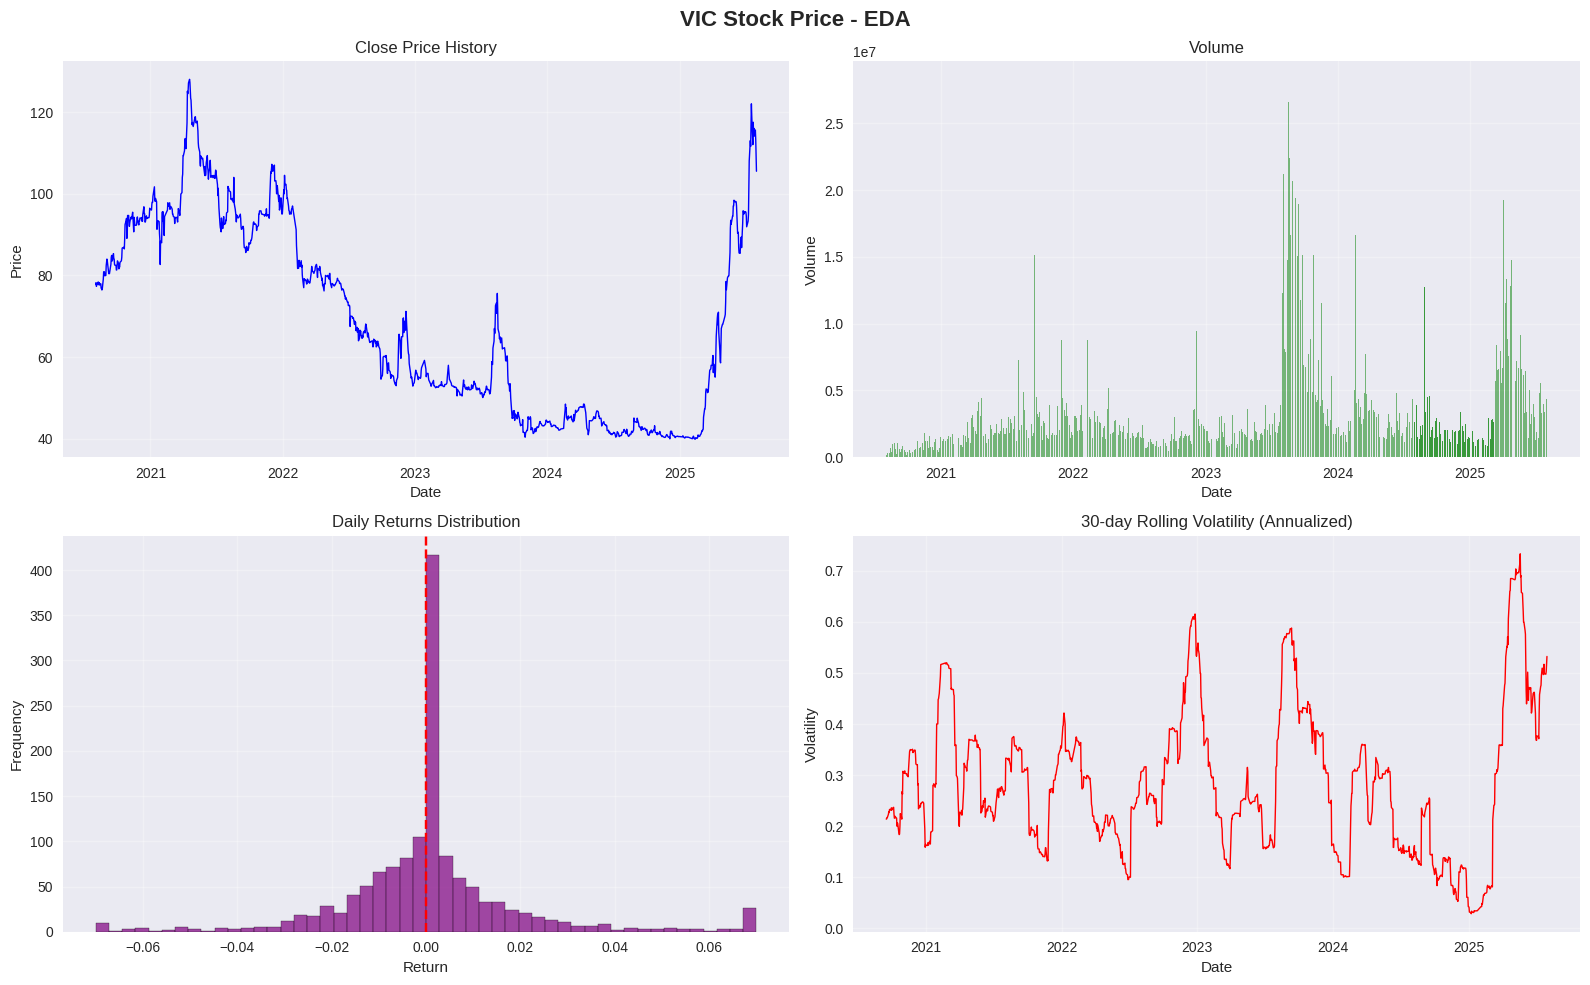

In [5]:
# Visualize price history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('VIC Stock Price - EDA', fontsize=16, fontweight='bold')

# Price history
axes[0, 0].plot(df['time'], df['close'], color='blue', linewidth=1)
axes[0, 0].set_title('Close Price History')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].grid(True, alpha=0.3)

# Volume
axes[0, 1].bar(df['time'], df['volume'], color='green', alpha=0.5, width=1)
axes[0, 1].set_title('Volume')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Daily returns distribution
returns = df['close'].pct_change().dropna()
axes[1, 0].hist(returns, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Daily Returns Distribution')
axes[1, 0].set_xlabel('Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

# Rolling volatility
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
axes[1, 1].plot(df['time'].iloc[1:], rolling_vol, color='red', linewidth=1)
axes[1, 1].set_title('30-day Rolling Volatility (Annualized)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Data Splitting & Feature Engineering

> **QUAN TRỌNG**: 
> - Chia data THỰC SỰ thành `df_train`, `df_val`, `df_test`
> - Feature Engineering được áp dụng riêng trên từng tập
> - Rolling features chỉ sử dụng past data trong tập train

DATA SPLITTING
Set             | Start        | End          | Length    
------------------------------------------------------------
TRAIN           | 0            | 839          | 839       
VALIDATION      | 839          | 1049         | 210       
INTERNAL TEST   | 1049         | 1400         | 351       
------------------------------------------------------------
TOTAL           |              |              | 1400      
Set             | Start Index  | End Index    | Length    
-------------------------------------------------------
TRAIN           | 0            | 1040         | 1040
VALIDATION      | 1040         | 1300         | 260
INTERNAL TEST   | 1300         | 1400         | 100
-------------------------------------------------------


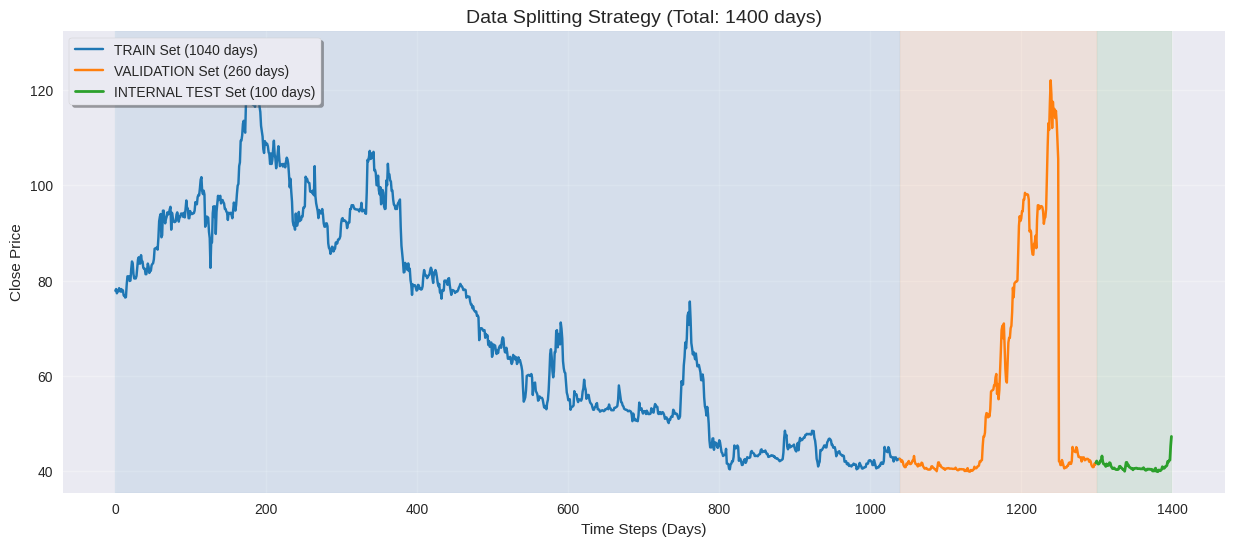

In [6]:
# === DATA SPLITTING (THỰC SỰ) ===
# Chia data TRƯỚC Feature Engineering để tránh data leakage

TRAIN_END = 839      # Train: 0 -> 839 (839 days)
VAL_END = 1049       # Val: 839 -> 1049 (210 days)
# TEST: 1049 -> end (100 days)

# THỰC SỰ CHIA DATA
df_train = df.iloc[:TRAIN_END].copy().reset_index(drop=True)
df_val = df.iloc[TRAIN_END:VAL_END].copy().reset_index(drop=True)
df_test = df.iloc[VAL_END:].copy().reset_index(drop=True)

print("="*60)
print("DATA SPLITTING")
print("="*60)
print(f"{'Set':<15} | {'Start':<12} | {'End':<12} | {'Length':<10}")
print("-"*60)
print(f"{'TRAIN':<15} | {'0':<12} | {TRAIN_END:<12} | {len(df_train):<10}")
print(f"{'VALIDATION':<15} | {TRAIN_END:<12} | {VAL_END:<12} | {len(df_val):<10}")
print(f"{'INTERNAL TEST':<15} | {VAL_END:<12} | {len(df):<12} | {len(df_test):<10}")
print("-"*60)
print(f"{'TOTAL':<15} | {'':<12} | {'':<12} | {len(df):<10}")

# Lưu split info
SPLIT_INFO = {
    'train_end': TRAIN_END,
    'val_end': VAL_END,
    'test_end': len(df),
    'df_train': df_train,
    'df_val': df_val,
    'df_test': df_test
}

def plot_data_split():
    # 1. Lấy dữ liệu gốc
    df_plot = pd.read_csv(DATA_PATH) # Đảm bảo đường dẫn đúng
    data = df_plot['close'].values
    total_len = len(data)
    
    # 2. Tính toán các điểm cắt (Theo logic của code tối ưu)
    TEST_LEN = 100
    
    # Phần dành cho phát triển model (Dev Set)
    dev_len = total_len - TEST_LEN
    
    # Trong Dev Set, chia 80% Train, 20% Val
    train_len = int(dev_len * 0.8)
    val_len = dev_len - train_len
    
    # 3. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    
    # Vẽ vùng Train
    plt.plot(range(0, train_len), data[0:train_len], 
             color='#1f77b4', label=f'TRAIN Set ({train_len} days)')
    
    # Vẽ vùng Validation (nối tiếp Train)
    plt.plot(range(train_len - 1, dev_len), data[train_len - 1:dev_len], 
             color='#ff7f0e', label=f'VALIDATION Set ({val_len} days)')
    
    # Vẽ vùng Test (nối tiếp Val)
    plt.plot(range(dev_len - 1, total_len), data[dev_len - 1:total_len], 
             color='#2ca02c', linewidth=2, label=f'INTERNAL TEST Set ({TEST_LEN} days)')
    
    # Tô màu nền để dễ phân biệt
    plt.axvspan(0, train_len, color='#1f77b4', alpha=0.1)
    plt.axvspan(train_len, dev_len, color='#ff7f0e', alpha=0.1)
    plt.axvspan(dev_len, total_len, color='#2ca02c', alpha=0.1)
    
    # Chú thích
    plt.title(f"Data Splitting Strategy (Total: {total_len} days)", fontsize=14)
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Close Price")
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    
    # In ra index cụ thể
    print(f"{'Set':<15} | {'Start Index':<12} | {'End Index':<12} | {'Length':<10}")
    print("-" * 55)
    print(f"{'TRAIN':<15} | {0:<12} | {train_len:<12} | {train_len}")
    print(f"{'VALIDATION':<15} | {train_len:<12} | {dev_len:<12} | {val_len}")
    print(f"{'INTERNAL TEST':<15} | {dev_len:<12} | {total_len:<12} | {TEST_LEN}")
    print("-" * 55)
    
    plt.show()

plot_data_split()

In [7]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("✓ No missing values!")

✓ No missing values!


In [8]:
# === FEATURE ENGINEERING FUNCTION ===
def apply_feature_engineering(df_input):
    """
    Apply feature engineering to a dataframe.
    Point-wise transforms + rolling features.
    """
    df_out = df_input.copy()
    
    # === Point-wise transforms (SAFE) ===
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df_out[f'{col}_log'] = np.log1p(df_out[col])
    
    df_out['HL_Spread'] = df_out['high_log'] - df_out['low_log']
    df_out['OC_Spread'] = df_out['close_log'] - df_out['open_log']
    
    # === Rolling features ===
    df_out['returns'] = df_out['close'].pct_change().fillna(0)
    df_out['volatility'] = df_out['returns'].rolling(window=10, min_periods=1).std().fillna(0)
    df_out['trend'] = df_out['close'].rolling(window=10, min_periods=1).mean().pct_change().fillna(0)
    
    return df_out

# === APPLY FE ===
print("Applying Feature Engineering...")

# 1. FE cho Train và Val (internal testing)
df_train = apply_feature_engineering(df_train)
df_val = apply_feature_engineering(df_val)
df_trainval = pd.concat([df_train, df_val], ignore_index=True)

# 2. df_test: Chỉ giữ 'close' để compare (NO FE needed)
test_actual_prices = df_test['close'].values

# 3. df_full: TOÀN BỘ data gốc với FE (cho PRODUCTION RETRAIN)
#    Đây là df gốc ban đầu, apply FE cho production
df_full = apply_feature_engineering(df.copy())

# Update SPLIT_INFO
SPLIT_INFO['df_train'] = df_train
SPLIT_INFO['df_val'] = df_val
SPLIT_INFO['df_trainval'] = df_trainval
SPLIT_INFO['test_actual_prices'] = test_actual_prices
SPLIT_INFO['df_full'] = df_full  # For production retrain

print(f"\n✓ Feature Engineering completed!")
print(f"\nFor INTERNAL TESTING:")
print(f"  - df_train:    {df_train.shape}")
print(f"  - df_val:      {df_val.shape}")
print(f"  - df_trainval: {df_trainval.shape}")
print(f"  - test_actual_prices: {len(test_actual_prices)} values")
print(f"\nFor PRODUCTION RETRAIN:")
print(f"  - df_full:     {df_full.shape} (ALL data with FE)")

display(df_full.tail(3))



Applying Feature Engineering...

✓ Feature Engineering completed!

For INTERNAL TESTING:
  - df_train:    (839, 17)
  - df_val:      (210, 17)
  - df_trainval: (1049, 17)
  - test_actual_prices: 351 values

For PRODUCTION RETRAIN:
  - df_full:     (1400, 17) (ALL data with FE)


,time,open,high,low,close,volume,symbol,open_log,high_log,low_log,close_log,volume_log,HL_Spread,OC_Spread,returns,volatility,trend
1397,2025-07-29,115.0,117.2,113.0,113.2,4570942,VIC,4.753590,4.772378,4.736198,4.737951,15.335230,0.036180,-0.015639,-0.020761,0.036624,0.001379
1398,2025-07-30,113.2,114.0,108.1,109.5,4362773,VIC,4.737951,4.744932,4.692265,4.705016,15.288619,0.052667,-0.032936,-0.032686,0.033443,-0.006800
1399,2025-07-31,108.7,109.5,105.0,105.5,5680304,VIC,4.697749,4.705016,4.663439,4.668145,15.552515,0.041576,-0.029604,-0.036530,0.030399,-0.014299


## 5. Dataset và Sliding Window

In [9]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series forecasting"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def create_sliding_window(data, seq_len, pred_len, target_col_idx, feature_cols_idx):
    """
    Create sliding window sequences for time series forecasting.
    """
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i : i + seq_len, feature_cols_idx])
        y.append(data[i + seq_len : i + seq_len + pred_len, target_col_idx])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print("Dataset classes defined!")

Dataset classes defined!


## 6. Regime Detector (Hidden Markov Model)

In [10]:
class RegimeDetector:
    """
    Detect market regimes using Gaussian HMM.
    Uses returns, volatility, and trend as features.
    FIX: Separate fit() and predict() to avoid data leakage.
    """
    def __init__(self, n_components=3, window=30):
        self.n_components = n_components
        self.window = window
        self.model = GaussianHMM(
            n_components=n_components, 
            covariance_type="full", 
            n_iter=100, 
            random_state=42
        )
        self.scaler = None  # Store scaler for later use
        
    def fit(self, df):
        """Fit HMM only on given data (should be train data)"""
        features = df[['returns', 'volatility', 'trend']].iloc[self.window:].values
        self.scaler = StandardScaler()
        features_scaled = self.scaler.fit_transform(features)
        self.model.fit(features_scaled)
        return self
    
    def predict(self, df):
        """Predict regimes for any data (can include future data)"""
        features = df[['returns', 'volatility', 'trend']].iloc[self.window:].values
        features_scaled = self.scaler.transform(features)  # Use fitted scaler
        states = self.model.predict(features_scaled)
        full_states = np.concatenate([np.zeros(self.window) - 1, states])
        return full_states.astype(int)
    
    def fit_predict(self, df):
        """Original method for backward compatibility"""
        self.fit(df)
        return self.predict(df)

print("RegimeDetector class defined (with separate fit/predict)!")

RegimeDetector class defined (with separate fit/predict)!


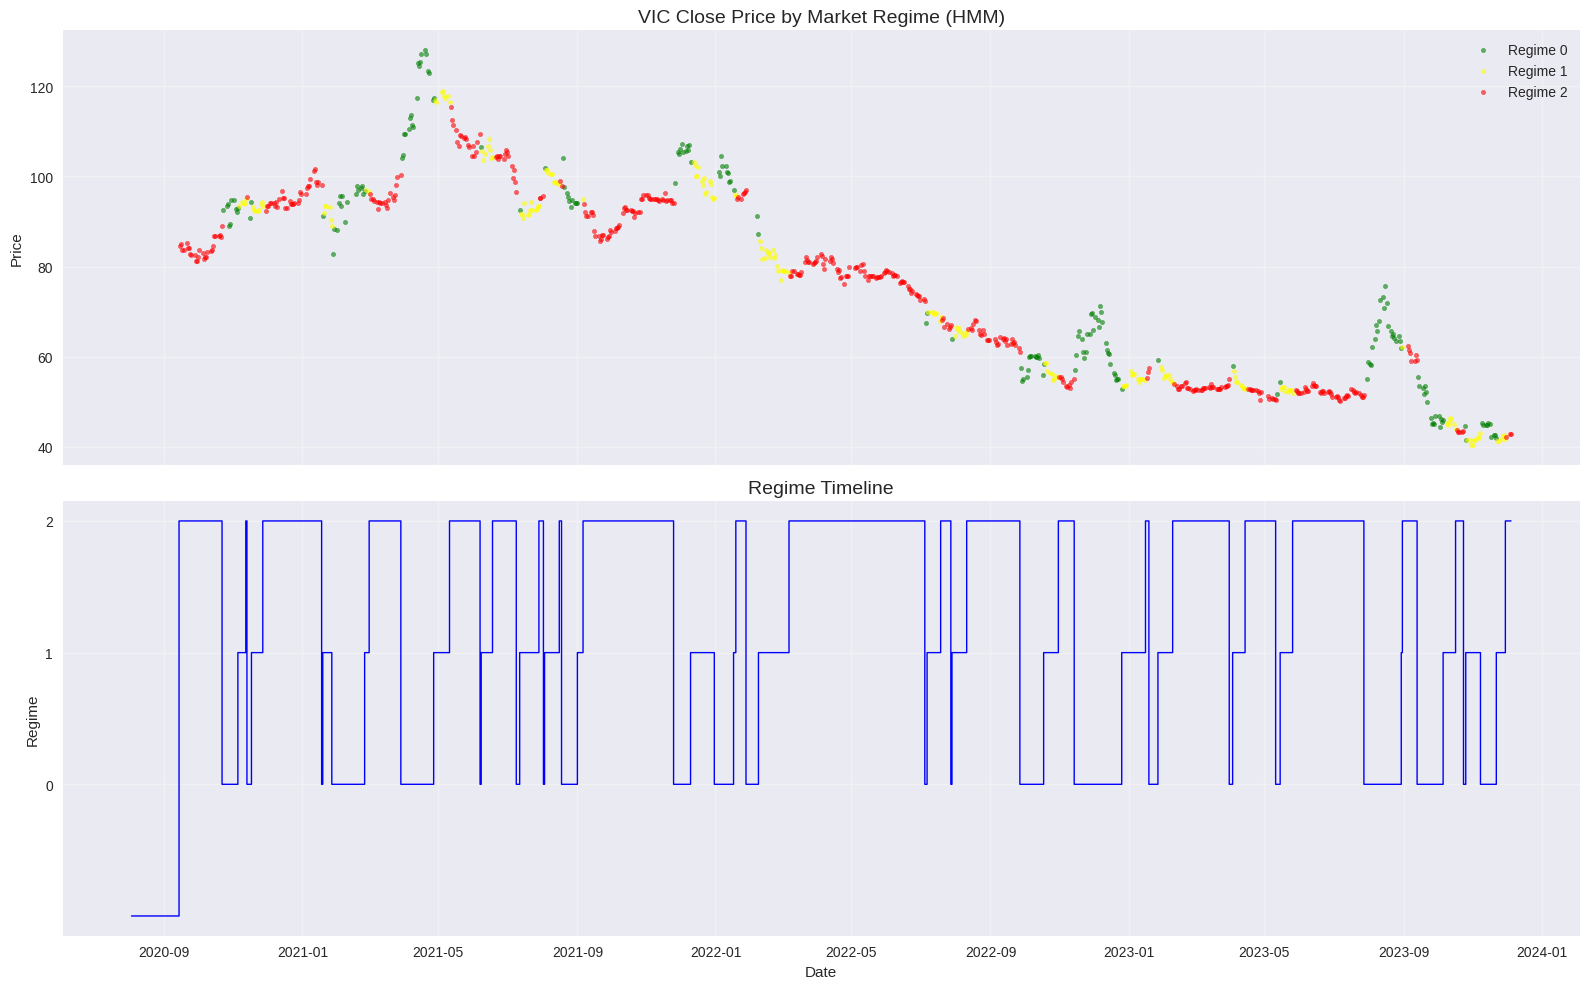


Regime Distribution:
  Regime 0: 189 days (22.5%)
  Regime 1: 186 days (22.2%)
  Regime 2: 434 days (51.7%)


In [11]:
# Visualize HMM Regimes
detector = RegimeDetector(n_components=3, window=30)
regimes = detector.fit_predict(df_train)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

colors = ['green', 'yellow', 'red']
for regime in range(3):
    mask = regimes == regime
    axes[0].scatter(df_train['time'][mask], df_train['close'][mask], 
                   c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=10)

axes[0].set_title('VIC Close Price by Market Regime (HMM)', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_train['time'], regimes, drawstyle='steps', color='blue', linewidth=1)
axes[1].set_title('Regime Timeline', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Regime')
axes[1].set_yticks([0, 1, 2])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegime Distribution:")
for r in range(3):
    count = (regimes == r).sum()
    pct = count / len(regimes) * 100
    print(f"  Regime {r}: {count} days ({pct:.1f}%)")

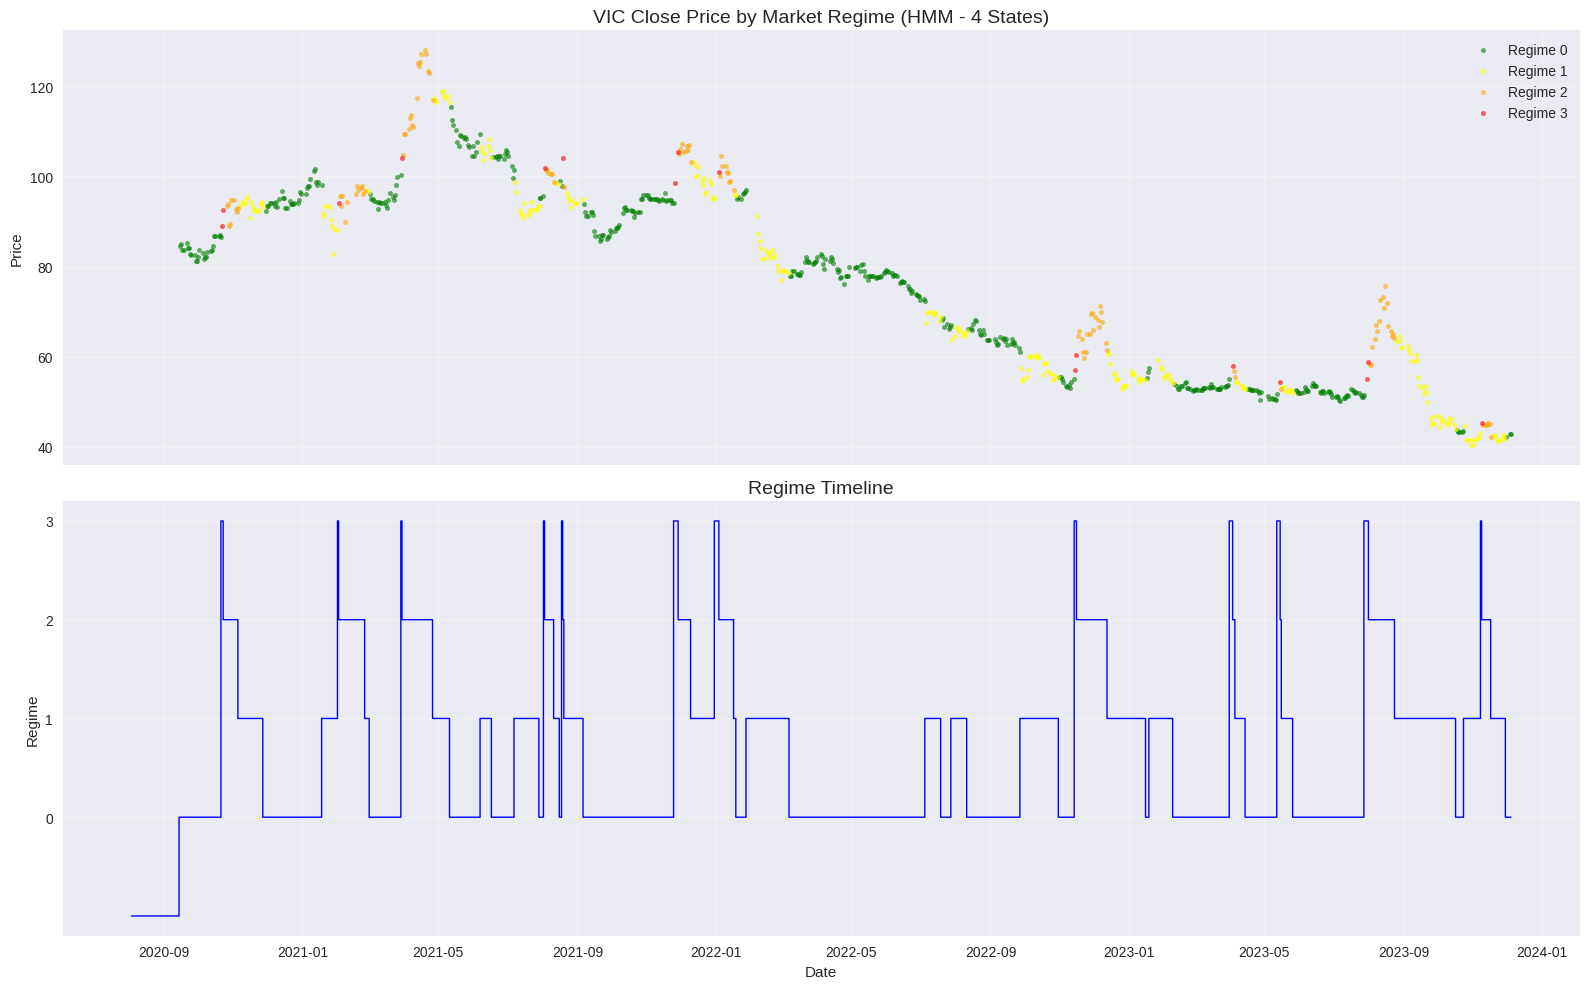


Regime Distribution:
  Regime 0: 425 days (50.7%)
  Regime 1: 259 days (30.9%)
  Regime 2: 109 days (13.0%)
  Regime 3: 16 days (1.9%)


In [12]:
# Visualize HMM Regimes (4 States)
detector = RegimeDetector(n_components=4, window=30)
regimes = detector.fit_predict(df_train)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# 4 màu cho 4 regimes
colors = ['green', 'yellow', 'orange', 'red'] 

for regime in range(4):
    mask = regimes == regime
    # Dùng try-except đề phòng trường hợp HMM ra ít hơn 4 nhóm (hiếm gặp)
    if mask.sum() > 0:
        axes[0].scatter(df_train['time'][mask], df_train['close'][mask], 
                       c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=10)

axes[0].set_title('VIC Close Price by Market Regime (HMM - 4 States)', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_train['time'], regimes, drawstyle='steps', color='blue', linewidth=1)
axes[1].set_title('Regime Timeline', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Regime')

axes[1].set_yticks([0, 1, 2, 3]) 
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegime Distribution:")
for r in range(4):
    count = (regimes == r).sum()
    pct = count / len(regimes) * 100
    print(f"  Regime {r}: {count} days ({pct:.1f}%)")

## 7. RevIN (Reversible Instance Normalization)

In [13]:
class RevIN(nn.Module):
    """
    Reversible Instance Normalization.
    Handles distribution shift in time series forecasting.
    """
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        return x

print("RevIN class defined!")

RevIN class defined!


## 8. LTSF-Linear Models (All Variants)

In [14]:
import torch
import torch.nn as nn


# =====================================================
# HELPER: Moving average decomposition kiểu code 2
# =====================================================

def uni_decompose(x, moving_avg, seq_len):
    """
    x: [B, S] (1 feature đã chọn)
    moving_avg: AvgPool1d
    return: trend, seasonal đều [B, S]
    """
    x_in = x.unsqueeze(1)      # [B, 1, S]
    trend = moving_avg(x_in).squeeze(1)  # [B, S']
    if trend.shape[1] != seq_len:
        trend = trend[:, :seq_len]
    seasonal = x - trend
    return trend, seasonal


def multi_decompose(x, moving_avg, seq_len):
    """
    x: [B, S, F]
    moving_avg: AvgPool1d
    return: trend, seasonal [B, S, F]
    """
    trend = moving_avg(x.permute(0, 2, 1)).permute(0, 2, 1)  # [B, S', F]
    if trend.shape[1] != seq_len:
        trend = trend[:, :seq_len, :]
    seasonal = x - trend
    return trend, seasonal


# ---------------------------
# UNIVARIATE MODELS (updated to accept any num_features but use a target_channel)
# Input: [B, L, C]  -> use channel self.target_channel -> output [B, pred_len]
# ---------------------------

class Uni_Linear_RevIN(nn.Module):
    """Univariate Linear với RevIN (pipeline code 2)"""
    def __init__(self, seq_len, pred_len, num_features, target_channel=0):
        super().__init__()
        self.target_channel = target_channel
        self.revin = RevIN(num_features)
        self.linear = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, self.target_channel]   # [B, 1] or [B]
        target_stdev = self.revin.stdev[:, :, self.target_channel]

        x_in = x[:, :, self.target_channel]                        # [B, L]
        out = self.linear(x_in)                 # [B, pred_len]
        out = out * target_stdev + target_mean
        return out


class Uni_Linear_NoRevIN(nn.Module):
    """Univariate Linear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features, target_channel=0):
        super().__init__()
        self.target_channel = target_channel
        self.linear = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        x_in = x[:, :, self.target_channel]                        # [B, L]
        return self.linear(x_in)                 # [B, pred_len]


class Uni_DLinear_RevIN(nn.Module):
    """Univariate DLinear với RevIN + decomposition code 2"""
    def __init__(self, seq_len, pred_len, num_features, kernel_size=25, target_channel=0):
        super().__init__()
        self.seq_len = seq_len
        self.target_channel = target_channel
        self.revin = RevIN(num_features)
        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, self.target_channel]
        target_stdev = self.revin.stdev[:, :, self.target_channel]

        x_in = x[:, :, self.target_channel]                        # [B, L]
        trend, seasonal = uni_decompose(x_in, self.moving_avg, self.seq_len)
        out = self.linear_trend(trend) + self.linear_seasonal(seasonal)
        out = out * target_stdev + target_mean
        return out


class Uni_DLinear_NoRevIN(nn.Module):
    """Univariate DLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features, kernel_size=25, target_channel=0):
        super().__init__()
        self.seq_len = seq_len
        self.target_channel = target_channel
        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x_in = x[:, :, self.target_channel]
        trend, seasonal = uni_decompose(x_in, self.moving_avg, self.seq_len)
        return self.linear_trend(trend) + self.linear_seasonal(seasonal)


class Uni_NLinear_NoRevIN(nn.Module):
    """Univariate NLinear không RevIN (normalization last value)"""
    def __init__(self, seq_len, pred_len, num_features, target_channel=0):
        super().__init__()
        self.target_channel = target_channel
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x_in = x[:, :, self.target_channel]                        # [B, L]
        last_value = x_in[:, -1:]               # [B, 1]
        x_normalized = x_in - last_value
        pred_normalized = self.linear(x_normalized)
        return pred_normalized + last_value      # [B, pred_len]


# ---------------- GLinear (Uni) ----------------

class Uni_GLinear_RevIN(nn.Module):
    """
    Univariate GLinear với RevIN:
    - RevIN (style code 2)
    - 2 linear theo thời gian + GELU
    """
    def __init__(self, seq_len, pred_len, num_features, hidden_dim=None, target_channel=0):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_channel = target_channel
        self.revin = RevIN(num_features)
        if hidden_dim is None:
            hidden_dim = seq_len
        self.linear1 = nn.Linear(seq_len, hidden_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, self.target_channel]
        target_stdev = self.revin.stdev[:, :, self.target_channel]

        x_in = x[:, :, self.target_channel]                        # [B, L]
        h = self.linear1(x_in)
        h = self.gelu(h)
        out = self.linear2(h)                   # [B, pred_len]
        out = out * target_stdev + target_mean
        return out


class Uni_GLinear_NoRevIN(nn.Module):
    """Univariate GLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features, hidden_dim=None, target_channel=0):
        super().__init__()
        self.target_channel = target_channel
        self.seq_len = seq_len
        self.pred_len = pred_len
        if hidden_dim is None:
            hidden_dim = seq_len
        self.linear1 = nn.Linear(seq_len, hidden_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x_in = x[:, :, self.target_channel]
        h = self.linear1(x_in)
        h = self.gelu(h)
        return self.linear2(h)                  # [B, pred_len]


# ---------------- GDLinear (Uni) - seasonal GELU only ----------------

class Uni_GDLinear_RevIN(nn.Module):
    """
    Univariate GDLinear với RevIN:
    - Seasonal: Linear -> GELU -> Linear
    - Trend:   Linear -> Linear (no activation)
    - Decomposition kiểu code 2
    """
    def __init__(self, seq_len, pred_len, num_features,
                 kernel_size=25, hidden_dim=None, target_channel=0):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_channel = target_channel
        self.revin = RevIN(num_features)
        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        if hidden_dim is None:
            hidden_dim = seq_len

        # seasonal branch: non-linear
        self.seasonal_linear1 = nn.Linear(seq_len, hidden_dim)
        self.seasonal_gelu = nn.GELU()
        self.seasonal_linear2 = nn.Linear(hidden_dim, pred_len)

        # trend branch: linear-only
        self.trend_linear1 = nn.Linear(seq_len, hidden_dim)
        self.trend_linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, self.target_channel]
        target_stdev = self.revin.stdev[:, :, self.target_channel]

        x_in = x[:, :, self.target_channel]                        # [B, L]
        trend, seasonal = uni_decompose(x_in, self.moving_avg, self.seq_len)

        # seasonal: có GELU
        s = self.seasonal_linear1(seasonal)
        s = self.seasonal_gelu(s)
        s = self.seasonal_linear2(s)

        # trend: không activation
        t = self.trend_linear1(trend)
        t = self.trend_linear2(t)

        out = s + t                              # [B, pred_len]
        out = out * target_stdev + target_mean
        return out


class Uni_GDLinear_NoRevIN(nn.Module):
    """Univariate GDLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features,
                 kernel_size=25, hidden_dim=None, target_channel=0):
        super().__init__()
        self.seq_len = seq_len
        self.target_channel = target_channel
        self.pred_len = pred_len
        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        if hidden_dim is None:
            hidden_dim = seq_len

        self.seasonal_linear1 = nn.Linear(seq_len, hidden_dim)
        self.seasonal_gelu = nn.GELU()
        self.seasonal_linear2 = nn.Linear(hidden_dim, pred_len)

        self.trend_linear1 = nn.Linear(seq_len, hidden_dim)
        self.trend_linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x_in = x[:, :, self.target_channel]
        trend, seasonal = uni_decompose(x_in, self.moving_avg, self.seq_len)

        s = self.seasonal_linear1(seasonal)
        s = self.seasonal_gelu(s)
        s = self.seasonal_linear2(s)

        t = self.trend_linear1(trend)
        t = self.trend_linear2(t)

        return s + t                              # [B, pred_len]



# =====================================================
# MULTIVARIATE MODELS (input [B, L, C] -> output [B, pred_len])
# =====================================================

class Multi_Linear_RevIN(nn.Module):
    """Multivariate Linear với RevIN (flatten giống code 2)"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.revin = RevIN(num_features)
        self.linear = nn.Linear(seq_len * num_features, pred_len)
        
    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]

        x_flat = x.reshape(x.shape[0], -1)       # [B, L*C]
        out = self.linear(x_flat)               # [B, pred_len]
        out = out * target_stdev + target_mean
        return out


class Multi_Linear_NoRevIN(nn.Module):
    """Multivariate Linear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.linear = nn.Linear(seq_len * num_features, pred_len)
        
    def forward(self, x):
        x_flat = x.reshape(x.shape[0], -1)
        return self.linear(x_flat)


class Multi_DLinear_RevIN(nn.Module):
    """Multivariate DLinear với RevIN + decomposition code 2"""
    def __init__(self, seq_len, pred_len, num_features, kernel_size=25):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.revin = RevIN(num_features)

        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        self.linear_trend = nn.Linear(seq_len * num_features, pred_len)
        self.linear_seasonal = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]

        trend, seasonal = multi_decompose(x, self.moving_avg, self.seq_len)
        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)

        out = self.linear_trend(trend_flat) + self.linear_seasonal(seasonal_flat)
        out = out * target_stdev + target_mean
        return out


class Multi_DLinear_NoRevIN(nn.Module):
    """Multivariate DLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features, kernel_size=25):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features

        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)
        self.linear_trend = nn.Linear(seq_len * num_features, pred_len)
        self.linear_seasonal = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        trend, seasonal = multi_decompose(x, self.moving_avg, self.seq_len)
        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)
        return self.linear_trend(trend_flat) + self.linear_seasonal(seasonal_flat)


class Multi_NLinear_NoRevIN(nn.Module):
    """Multivariate NLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.linear = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        last_values = x[:, -1:, :]              # [B, 1, C]
        x_normalized = x - last_values
        x_flat = x_normalized.reshape(x.shape[0], -1)
        pred_normalized = self.linear(x_flat)
        # dùng close (channel 0) làm target
        return pred_normalized + last_values[:, 0, 0:1]   # [B, pred_len]


# ---------------- GLinear (Multi) ----------------

class Multi_GLinear_RevIN(nn.Module):
    """
    Multivariate GLinear với RevIN:
    - flatten (L*C) -> hidden_dim -> pred_len
    """
    def __init__(self, seq_len, pred_len, num_features, hidden_dim=512):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.revin = RevIN(num_features)
        in_dim = seq_len * num_features
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]

        x_flat = x.reshape(x.shape[0], -1)
        h = self.linear1(x_flat)
        h = self.gelu(h)
        out = self.linear2(h)                   # [B, pred_len]
        out = out * target_stdev + target_mean
        return out


class Multi_GLinear_NoRevIN(nn.Module):
    """Multivariate GLinear không RevIN"""
    def __init__(self, seq_len, pred_len, num_features, hidden_dim=512):
        super().__init__()
        in_dim = seq_len * num_features
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        x_flat = x.reshape(x.shape[0], -1)
        h = self.linear1(x_flat)
        h = self.gelu(h)
        return self.linear2(h)


# ---------------- GDLinear (Multi) ----------------

class Multi_GDLinear_RevIN(nn.Module):
    """
    Multivariate GDLinear với RevIN:
    - Seasonal: flatten -> Linear -> GELU -> Linear
    - Trend:   flatten -> Linear -> Linear
    - Decomposition kiểu code 2
    """
    def __init__(self, seq_len, pred_len, num_features,
                 kernel_size=25, hidden_dim=512):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.revin = RevIN(num_features)

        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)

        in_dim = seq_len * num_features

        # seasonal: non-linear
        self.seasonal_linear1 = nn.Linear(in_dim, hidden_dim)
        self.seasonal_gelu = nn.GELU()
        self.seasonal_linear2 = nn.Linear(hidden_dim, pred_len)

        # trend: linear-only
        self.trend_linear1 = nn.Linear(in_dim, hidden_dim)
        self.trend_linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]

        trend, seasonal = multi_decompose(x, self.moving_avg, self.seq_len)

        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)

        s = self.seasonal_linear1(seasonal_flat)
        s = self.seasonal_gelu(s)
        s = self.seasonal_linear2(s)

        t = self.trend_linear1(trend_flat)
        t = self.trend_linear2(t)

        out = s + t                              # [B, pred_len]
        out = out * target_stdev + target_mean
        return out



class Multi_GDLinear_NoRevIN(nn.Module):
    """
    Multivariate GDLinear không RevIN:
    - Seasonal: flatten -> Linear -> GELU -> Linear
    - Trend:   flatten -> Linear -> Linear
    """
    def __init__(self, seq_len, pred_len, num_features,
                 kernel_size=25, hidden_dim=512):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features

        ks = min(kernel_size, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=ks, stride=1, padding=ks // 2)

        in_dim = seq_len * num_features

        self.seasonal_linear1 = nn.Linear(in_dim, hidden_dim)
        self.seasonal_gelu = nn.GELU()
        self.seasonal_linear2 = nn.Linear(hidden_dim, pred_len)

        self.trend_linear1 = nn.Linear(in_dim, hidden_dim)
        self.trend_linear2 = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # x: [B, L, C]
        trend, seasonal = multi_decompose(x, self.moving_avg, self.seq_len)

        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)

        s = self.seasonal_linear1(seasonal_flat)
        s = self.seasonal_gelu(s)
        s = self.seasonal_linear2(s)

        t = self.trend_linear1(trend_flat)
        t = self.trend_linear2(t)

        return s + t                              # [B, pred_len]



In [15]:
# =====================================================
# MODEL REGISTRY - ALL MODELS (RevIN variants as default)
# =====================================================

MODEL_REGISTRY = {
    # ---------------------
    # Linear family
    # ---------------------
    ('Univariate', 'Linear'):     Uni_Linear_RevIN,
    ('Multivariate', 'Linear'):   Multi_Linear_RevIN,

    # ---------------------
    # DLinear family
    # ---------------------
    ('Univariate', 'DLinear'):    Uni_DLinear_RevIN,
    ('Multivariate', 'DLinear'):  Multi_DLinear_RevIN,

    # ---------------------
    # GLinear family
    # ---------------------
    ('Univariate', 'GLinear'):    Uni_GLinear_RevIN,
    ('Multivariate', 'GLinear'):  Multi_GLinear_RevIN,

    # ---------------------
    # GDLinear family (custom seasonal GELU only)
    # ---------------------
    ('Univariate', 'GDLinear'):   Uni_GDLinear_RevIN,
    ('Multivariate', 'GDLinear'): Multi_GDLinear_RevIN,
}


def create_model(variant, model_type, seq_len, pred_len, num_features):
    """
    Factory function to create model.

    variant: 'Univariate' or 'Multivariate'
    model_type: 'Linear', 'DLinear', 'GLinear', 'GDLinear'
    
    returns nn.Module
    """
    key = (variant, model_type)
    if key not in MODEL_REGISTRY:
        raise ValueError(f"Unknown model configuration: {key}")
    return MODEL_REGISTRY[key](seq_len, pred_len, num_features)


print(f"\n{'='*60}")
print(f"MODEL REGISTRY - ALL MODELS USE RevIN")
print(f"{'='*60}")
print(f"Total configurations: {len(MODEL_REGISTRY)}")
for (variant, model_type) in MODEL_REGISTRY:
    print(f"  ✓ {variant}_{model_type}")
print(f"{'='*60}")



MODEL REGISTRY - ALL MODELS USE RevIN
Total configurations: 8
  ✓ Univariate_Linear
  ✓ Multivariate_Linear
  ✓ Univariate_DLinear
  ✓ Multivariate_DLinear
  ✓ Univariate_GLinear
  ✓ Multivariate_GLinear
  ✓ Univariate_GDLinear
  ✓ Multivariate_GDLinear


## 9. Trainer Class

In [16]:
class Trainer:
    """Training manager with early stopping and learning rate scheduling."""
    def __init__(self, model, criterion, optimizer, scheduler, patience=10):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.patience = patience
        self.best_loss = float('inf')
        self.best_state = None
        self.counter = 0
        
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        """Train the model with early stopping"""
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            
            val_loss = self.evaluate(val_loader)
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_state = deepcopy(self.model.state_dict())
                self.counter = 0
            else:
                self.counter += 1
                
            if self.counter >= self.patience:
                break
                
        if self.best_state:
            self.model.load_state_dict(self.best_state)
            
    def evaluate(self, loader):
        """Evaluate model on a dataset"""
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                total_loss += loss.item()
        return total_loss / len(loader)

print("Trainer class defined!")

Trainer class defined!


## 10. Grid Search Pipeline

In [17]:
def inverse_transform(log_data):
    """Convert log-transformed data back to original scale"""
    return np.expm1(log_data)


def train_model_func(variant, model_type, seq_len, num_features, X_train, y_train, epochs=EPOCHS):
    """Helper function to train a single model"""
    train_loader = DataLoader(
        TimeSeriesDataset(X_train, y_train), 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    
    model = create_model(variant, model_type, seq_len, PRED_LEN, num_features).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    trainer = Trainer(model, criterion, optimizer, scheduler, patience=PATIENCE)
    trainer.fit(train_loader, train_loader, epochs)
    
    return model


def evaluate_model_func(model, X, y):
    """Evaluate model and compute MSE on original price scale"""
    model.eval()
    loader = DataLoader(TimeSeriesDataset(X, y), batch_size=BATCH_SIZE, shuffle=False)
    
    preds_log, trues_log = [], []
    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            out = model(X_b)
            preds_log.append(out.cpu().numpy())
            trues_log.append(y_b.numpy())
    
    preds_log = np.concatenate(preds_log)
    trues_log = np.concatenate(trues_log)
    
    preds_price = inverse_transform(preds_log)
    trues_price = inverse_transform(trues_log)
    
    return mean_squared_error(trues_price.flatten(), preds_price.flatten())


def save_submission(predictions, filename):
    """Save predictions to CSV file"""
    sub_df = pd.DataFrame({
        'id': range(1, PRED_LEN + 1), 
        'close': predictions
    })
    filepath = os.path.join(SUBMISSION_DIR, filename)
    sub_df.to_csv(filepath, index=False)
    return filepath


def save_plot(history_prices, predictions, filename, title):
    """Save forecast plot"""
    # fig, ax = plt.subplots(figsize=(12, 6))
    # ... (Keep commented out or implement if needed)
    pass

print("Training utilities defined!")

Training utilities defined!


In [18]:
def run_grid_search():
    """
    Main Grid Search Pipeline.
    Iterates over all model configurations.
    """
    results = []
    
    # Feature columns
    feature_cols = ['close_log', 'volume_log', 'HL_Spread', 'OC_Spread']
    target_col_idx = df_trainval.columns.get_loc('close_log')
    feature_cols_idx = [df_trainval.columns.get_loc(c) for c in feature_cols]
    # For internal testing
    data_values = df_trainval.values  # Use concatenated df
    
    # === ĐỊNH NGHĨA MỘT LẦN Ở ĐÂY ===
    PROD_TRAIN_RATIO = 0.95  # Dùng chung cho cả HMM và Model
    prod_train_size = int(len(data_values) * PROD_TRAIN_RATIO)
    
    # Calculate total combinations
    total = 0
    for variant in VARIANTS:
        for model_type in MODEL_TYPES:
            for seq_len in SEQ_LENS:
                for use_hmm in USE_HMM_OPTIONS:
                    if seq_len >= 120 and use_hmm:
                        continue
                    if use_hmm:
                        total += len(N_REGIMES_OPTIONS) * len(REGIME_WINDOWS)
                    else:
                        total += 1
                            
    pbar = tqdm(total=total, desc="Grid Search")
    
    for variant in VARIANTS:
        for model_type in MODEL_TYPES:
            for seq_len in SEQ_LENS:
                for use_hmm in USE_HMM_OPTIONS:
                    
                    if seq_len >= 120 and use_hmm:
                        continue
                    
                    hmm_configs = [(None, None)]
                    if use_hmm:
                        hmm_configs = [(n, w) for n in N_REGIMES_OPTIONS for w in REGIME_WINDOWS]
                    
                    for n_regimes, regime_window in hmm_configs:
                        try:
                            seed_everything(42)
                            
                            # === Data Preparation ===
                            regimes = None
                            if use_hmm:
                                detector = RegimeDetector(n_components=n_regimes, window=regime_window)
                                # Dùng prod_train_size đã định nghĩa ở trên
                                detector.fit(df_full.iloc[:prod_train_size])
                                regimes = detector.predict(df_full)
                            
                            # Train/Val split (80/20) - cho validation
                            train_size = SPLIT_INFO['train_end']  # Use fixed split
                            train_data = data_values[:train_size]
                            val_data = data_values[train_size - seq_len:]
                            
                            X_train, y_train = create_sliding_window(train_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                            X_val, y_val = create_sliding_window(val_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                            
                            num_features = len(feature_cols_idx)
                            
                            # === Train Global Model (Baseline) ===
                            global_model = train_model_func(variant, model_type, seq_len, num_features, X_train, y_train)
                            
                            # === Evaluation ===
                            if not use_hmm:
                                val_mse = evaluate_model_func(global_model, X_val, y_val)
                            else:
                                val_mse = evaluate_with_hmm(
                                    global_model, variant, model_type,
                                    seq_len, num_features,
                                    X_train, y_train, X_val, y_val,
                                    regimes, train_size
                                )
                            
                            # === Production Forecast ===
                            # Dùng prod_train_size đã định nghĩa (KHÔNG định nghĩa lại)
                            # For PRODUCTION: Use df_full (all data)
                            prod_data_values = df_full.values
                            prod_train_size = int(len(prod_data_values) * PROD_TRAIN_RATIO)
                            prod_train_data = prod_data_values[:prod_train_size]
                            X_prod, y_prod = create_sliding_window(prod_train_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                            
                            final_model = train_model_func(variant, model_type, seq_len, num_features, X_prod, y_prod, epochs=EPOCHS//2)
                            
                            # Prepare input for forecast
                            last_sequence = prod_data_values[-seq_len:, feature_cols_idx]
                            last_seq_tensor = torch.tensor(last_sequence.astype(np.float32)).unsqueeze(0).to(device)
                            
                            # Base Forecast
                            final_model.eval()
                            with torch.no_grad():
                                pred_log = final_model(last_seq_tensor).cpu().numpy().flatten()
                            
                            # Forecast with HMM regime
                            if use_hmm:
                                current_regime = regimes[-1]
                                
                                prod_regime_indices = []
                                for i in range(len(X_prod)):
                                    r_idx = i + seq_len - 1
                                    if r_idx < len(regimes):
                                        prod_regime_indices.append(regimes[r_idx])
                                    else:
                                        prod_regime_indices.append(-1)
                                
                                prod_regime_indices = np.array(prod_regime_indices)
                                mask = (prod_regime_indices == current_regime)
                                
                                if mask.sum() > 30:
                                    X_regime = X_prod[mask]
                                    y_regime = y_prod[mask]
                                    
                                    regime_model = train_model_func(variant, model_type, seq_len, num_features, 
                                                                  X_regime, y_regime, epochs=EPOCHS//2)
                                    
                                    regime_model.eval()
                                    with torch.no_grad():
                                        pred_log = regime_model(last_seq_tensor).cpu().numpy().flatten()
                            
                            # === Save Results ===
                            pred_price = inverse_transform(pred_log)
                            
                            hmm_status = f"HMM{n_regimes}W{regime_window}" if use_hmm else "NoHMM"
                            filename = f"Sub_{variant}_{model_type}_{hmm_status}_Seq{seq_len}_MSE{val_mse:.0f}.csv"
                            
                            save_submission(pred_price, filename)
                            
                            results.append({
                                'Variant': variant,
                                'Model': model_type,
                                'HMM': hmm_status,
                                'SeqLen': seq_len,
                                'ValMSE': val_mse,
                                'File': filename
                            })
                            
                            pbar.set_postfix({'Last': f"{variant[:3]}_{model_type}_{seq_len}", 'MSE': f"{val_mse:.0f}"})
                            
                        except Exception as e:
                            print(f"\n✗ Error: {variant}_{model_type}_Seq{seq_len}: {e}")
                            import traceback
                            traceback.print_exc()
                        
                        pbar.update(1)
    
    pbar.close()
    return results


def evaluate_with_hmm(global_model, variant, model_type, seq_len, num_features,
                      X_train, y_train, X_val, y_val, regimes, train_size):
    """Evaluate with regime-switching models"""
    regime_models = {}
    train_regimes = regimes[:train_size]
    unique_regimes = np.unique(train_regimes)
    
    # Map index X_train sang Regime
    train_regime_indices = []
    for i in range(len(X_train)):
        r_idx = i + seq_len - 1
        if r_idx < len(train_regimes):
            train_regime_indices.append(train_regimes[r_idx])
        else:
            train_regime_indices.append(-1)
    train_regime_indices = np.array(train_regime_indices)
    
    # Train model riêng cho từng regime
    for r in unique_regimes:
        if r == -1:
            continue
        mask = (train_regime_indices == r)
        if mask.sum() > 30:
            X_r = X_train[mask]
            y_r = y_train[mask]
            regime_models[r] = train_model_func(variant, model_type, seq_len, num_features, X_r, y_r)
    
    val_preds_log, val_trues_log = [], []
    
    global_model.eval()
    for model in regime_models.values():
        model.eval()
    
    with torch.no_grad():
        for i in range(len(X_val)):
            # Xác định regime của mẫu validation hiện tại
            global_idx = train_size + i - 1
            curr_regime = regimes[global_idx] if global_idx < len(regimes) else -1
            
            # Chọn model: Nếu có model regime thì dùng, ko thì dùng global
            selected_model = regime_models.get(curr_regime, global_model)
            
            inp = torch.tensor(X_val[i]).unsqueeze(0).to(device)
            pred = selected_model(inp).cpu().numpy()
            
            val_preds_log.append(pred)
            val_trues_log.append(y_val[i])
    
    val_preds_log = np.concatenate(val_preds_log)
    val_trues_log = np.array(val_trues_log)
    
    pred_price = inverse_transform(val_preds_log)
    true_price = inverse_transform(val_trues_log)
    
    return mean_squared_error(true_price.flatten(), pred_price.flatten())

print("Grid Search pipeline defined!")

Grid Search pipeline defined!


## 11. Run Grid Search

In [19]:
print("="*60)
print("STARTING GRID SEARCH")
print("="*60)
print(f"\nGrid Search Space:")
print(f"  - Variants: {VARIANTS}")
print(f"  - Models: {MODEL_TYPES}")
# print(f"  - RevIN: {USE_REVIN_OPTIONS}")
print(f"  - Seq Lengths: {SEQ_LENS}")
print(f"  - HMM: {USE_HMM_OPTIONS}")
print("\n")

results = run_grid_search()

print("\n" + "="*60)
print("GRID SEARCH COMPLETED")
print("="*60)

STARTING GRID SEARCH

Grid Search Space:
  - Variants: ['Univariate', 'Multivariate']
  - Models: ['DLinear', 'Linear']
  - Seq Lengths: [60, 480]
  - HMM: [False, True]




Grid Search: 100%|██████████| 16/16 [04:47<00:00, 17.96s/it, Last=Mul_Linear_480, MSE=93]


GRID SEARCH COMPLETED


## 12. Results Analysis

In [20]:
# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('ValMSE')
results_df.to_csv('results/VIC_grid_search_results.csv', index=False)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

print(f"\nTotal experiments: {len(results_df)}")
print(f"\nTop 15 Best Models:")
display(results_df.head(15))

print(f"\nWorst 5 Models:")
display(results_df.tail(5))


RESULTS SUMMARY

Total experiments: 16

Top 15 Best Models:


,Variant,Model,HMM,SeqLen,ValMSE,File
4,Univariate,Linear,NoHMM,60,9.544715,Sub_Univariate_Linear_NoHMM_Seq60_MSE10.csv
0,Univariate,DLinear,NoHMM,60,9.563109,Sub_Univariate_DLinear_NoHMM_Seq60_MSE10.csv
6,Univariate,Linear,HMM3W60,60,10.280424,Sub_Univariate_Linear_HMM3W60_Seq60_MSE10.csv
2,Univariate,DLinear,HMM3W60,60,10.469700,Sub_Univariate_DLinear_HMM3W60_Seq60_MSE10.csv
5,Univariate,Linear,HMM3W30,60,13.824180,Sub_Univariate_Linear_HMM3W30_Seq60_MSE14.csv
1,Univariate,DLinear,HMM3W30,60,15.248690,Sub_Univariate_DLinear_HMM3W30_Seq60_MSE15.csv
12,Multivariate,Linear,NoHMM,60,17.490740,Sub_Multivariate_Linear_NoHMM_Seq60_MSE17.csv
8,Multivariate,DLinear,NoHMM,60,17.602531,Sub_Multivariate_DLinear_NoHMM_Seq60_MSE18.csv
14,Multivariate,Linear,HMM3W60,60,26.733240,Sub_Multivariate_Linear_HMM3W60_Seq60_MSE27.csv
10,Multivariate,DLinear,HMM3W60,60,28.203381,Sub_Multivariate_DLinear_HMM3W60_Seq60_MSE28.csv



Worst 5 Models:


,Variant,Model,HMM,SeqLen,ValMSE,File
9,Multivariate,DLinear,HMM3W30,60,51.290131,Sub_Multivariate_DLinear_HMM3W30_Seq60_MSE51.csv
7,Univariate,Linear,NoHMM,480,72.071205,Sub_Univariate_Linear_NoHMM_Seq480_MSE72.csv
3,Univariate,DLinear,NoHMM,480,72.912506,Sub_Univariate_DLinear_NoHMM_Seq480_MSE73.csv
15,Multivariate,Linear,NoHMM,480,92.948601,Sub_Multivariate_Linear_NoHMM_Seq480_MSE93.csv
11,Multivariate,DLinear,NoHMM,480,98.190506,Sub_Multivariate_DLinear_NoHMM_Seq480_MSE98.csv


In [21]:
# Detailed Analysis
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

# By Variant
print("\n📊 Average MSE by Variant:")
print(results_df.groupby('Variant')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))

# By Model Type
print("\n📊 Average MSE by Model Type:")
print(results_df.groupby('Model')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))

# By Sequence Length
print("\n📊 Average MSE by Sequence Length:")
print(results_df.groupby('SeqLen')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))


DETAILED ANALYSIS

📊 Average MSE by Variant:
               mean    std    min    max
Variant                                 
Multivariate  47.77  32.19  17.49  98.19
Univariate    26.74  28.31   9.54  72.91

📊 Average MSE by Model Type:
          mean    std   min    max
Model                             
DLinear  37.94  32.98  9.56  98.19
Linear   36.57  31.65  9.54  92.95

📊 Average MSE by Sequence Length:
         mean    std    min    max
SeqLen                            
60      21.66  14.82   9.54  51.29
480     84.03  13.50  72.07  98.19


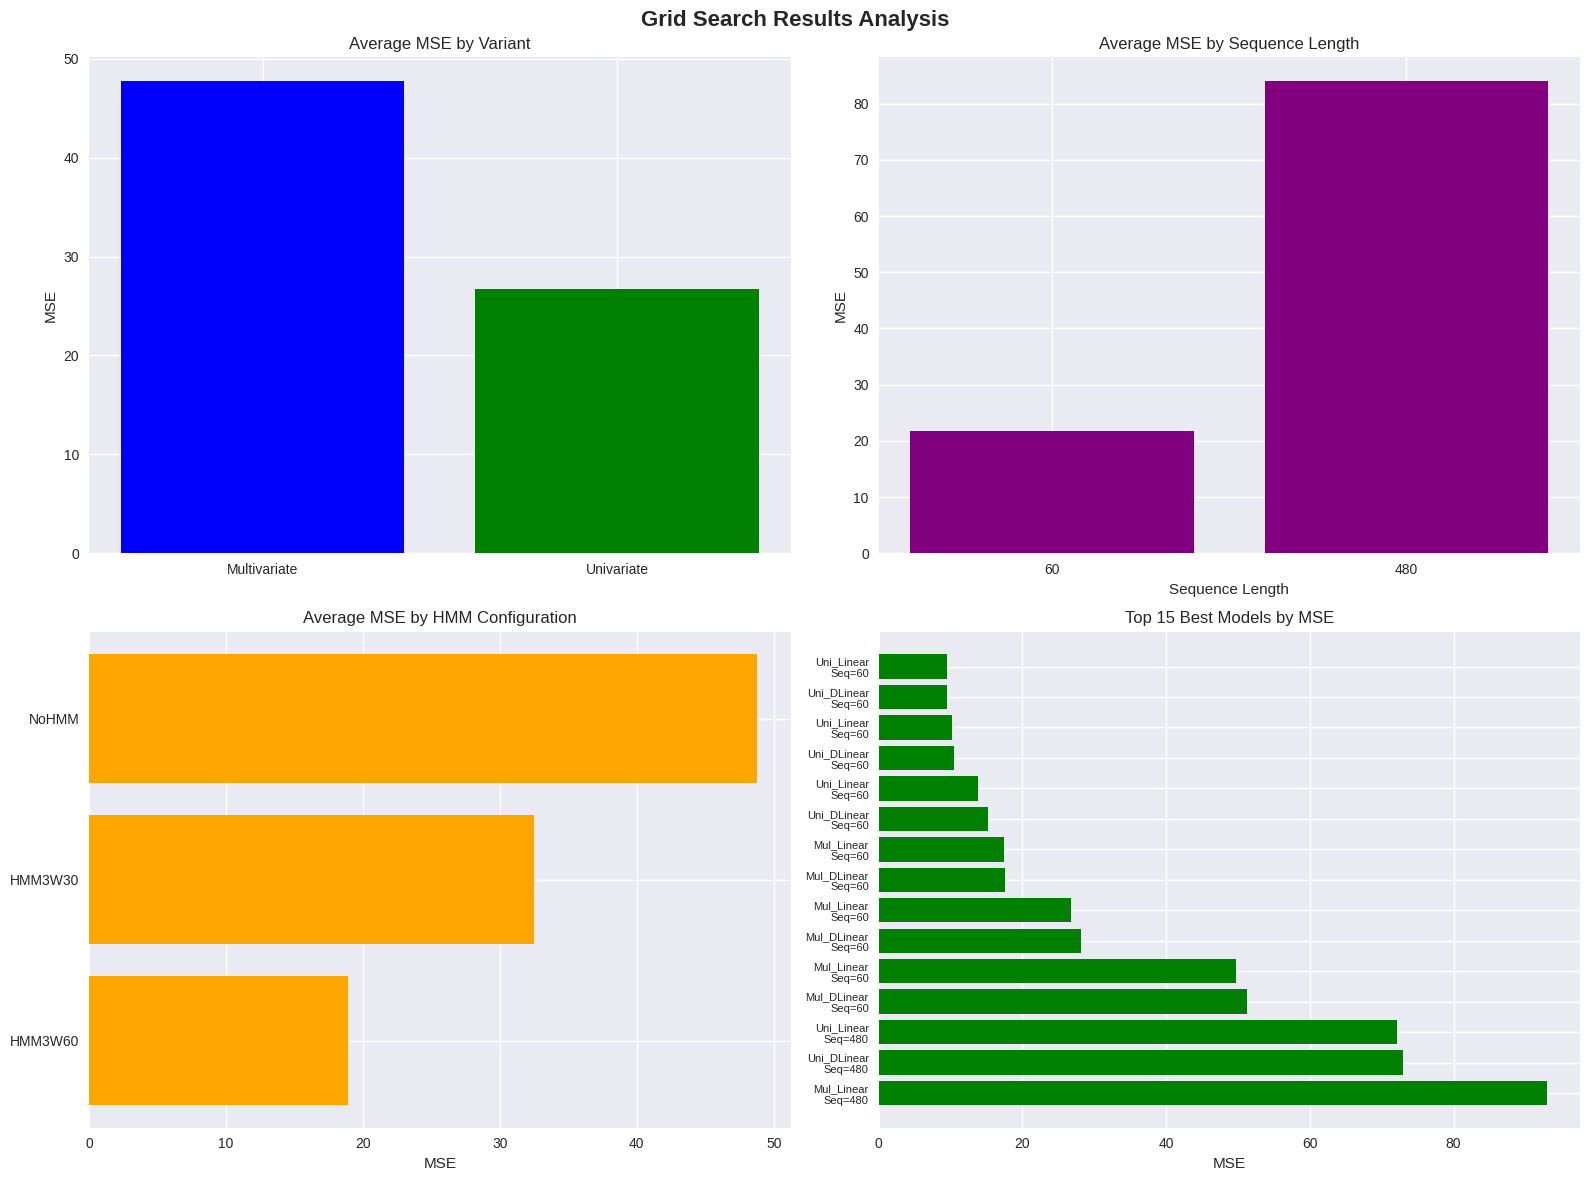

In [22]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Grid Search Results Analysis', fontsize=16, fontweight='bold')

# 1. MSE by Variant
variant_mse = results_df.groupby('Variant')['ValMSE'].mean()
axes[0, 0].bar(variant_mse.index, variant_mse.values, color=['blue', 'green'])
axes[0, 0].set_title('Average MSE by Variant', fontsize=12)
axes[0, 0].set_ylabel('MSE')

# 2. MSE by Sequence Length
seq_mse = results_df.groupby('SeqLen')['ValMSE'].mean()
axes[0, 1].bar(seq_mse.index.astype(str), seq_mse.values, color='purple')
axes[0, 1].set_title('Average MSE by Sequence Length', fontsize=12)
axes[0, 1].set_xlabel('Sequence Length')
axes[0, 1].set_ylabel('MSE')

# 3. MSE by HMM
hmm_mse = results_df.groupby('HMM')['ValMSE'].mean().sort_values()
axes[1, 0].barh(hmm_mse.index, hmm_mse.values, color='orange')
axes[1, 0].set_title('Average MSE by HMM Configuration', fontsize=12)
axes[1, 0].set_xlabel('MSE')

# 4. Top 15 Models
top15 = results_df.head(15)
labels = [f"{r['Variant'][:3]}_{r['Model']}\nSeq={r['SeqLen']}" for _, r in top15.iterrows()]
axes[1, 1].barh(range(len(top15)), top15['ValMSE'].values, color='green')
axes[1, 1].set_yticks(range(len(top15)))
axes[1, 1].set_yticklabels(labels, fontsize=8)
axes[1, 1].set_title('Top 15 Best Models by MSE', fontsize=12)
axes[1, 1].set_xlabel('MSE')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('results/VIC_grid_search_analysis.png', dpi=150)
plt.show()

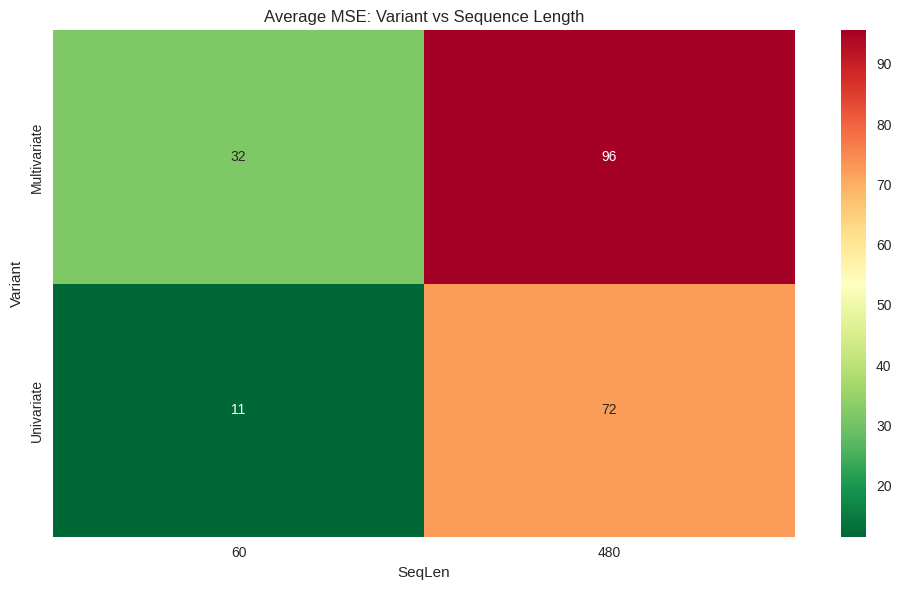

In [23]:
# Heatmap: Variant vs Sequence Length
pivot_seq = results_df.pivot_table(
    values='ValMSE', index='Variant', columns='SeqLen', aggfunc='mean'
)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_seq, annot=True, fmt='.0f', cmap='RdYlGn_r')
plt.title('Average MSE: Variant vs Sequence Length', fontsize=12)
plt.tight_layout()
plt.savefig('results/VIC_heatmap_analysis.png', dpi=150)
plt.show()

## 13. Summary và Kết luận

In [24]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset: VIC Stock ({len(df)} days)")
print(f"📅 Date Range: {df['time'].min().date()} to {df['time'].max().date()}")

print(f"\n🔬 Total Experiments: {len(results_df)}")

print(f"\n🏆 TOP 5 BEST MODELS:")
for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['Variant']}_{row['Model']} | Seq={row['SeqLen']} | {row['HMM']} | MSE={row['ValMSE']:.2f}")

print(f"\n📈 KEY FINDINGS:")
best_variant = results_df.groupby('Variant')['ValMSE'].mean().idxmin()
best_model = results_df.groupby('Model')['ValMSE'].mean().idxmin()
best_seq = results_df.groupby('SeqLen')['ValMSE'].mean().idxmin()

print(f"   - Best Variant: {best_variant}")
print(f"   - Best Model Type: {best_model}")
print(f"   - Best Sequence Length: {best_seq}")

print("\n" + "="*60)
print("DONE! 🎉")
print("="*60)

FINAL SUMMARY

📊 Dataset: VIC Stock (1400 days)
📅 Date Range: 2020-08-03 to 2025-07-31

🔬 Total Experiments: 16

🏆 TOP 5 BEST MODELS:
   1. Univariate_Linear | Seq=60 | NoHMM | MSE=9.54
   2. Univariate_DLinear | Seq=60 | NoHMM | MSE=9.56
   3. Univariate_Linear | Seq=60 | HMM3W60 | MSE=10.28
   4. Univariate_DLinear | Seq=60 | HMM3W60 | MSE=10.47
   5. Univariate_Linear | Seq=60 | HMM3W30 | MSE=13.82

📈 KEY FINDINGS:
   - Best Variant: Univariate
   - Best Model Type: Linear
   - Best Sequence Length: 60

DONE! 🎉


In [25]:
# List all submission files
print("\n📂 All Submission Files:")
print("-" * 80)
for i, filename in enumerate(sorted(results_df['File'].tolist()), 1):
    print(f"{i:3d}. {filename}")


📂 All Submission Files:
--------------------------------------------------------------------------------
  1. Sub_Multivariate_DLinear_HMM3W30_Seq60_MSE51.csv
  2. Sub_Multivariate_DLinear_HMM3W60_Seq60_MSE28.csv
  3. Sub_Multivariate_DLinear_NoHMM_Seq480_MSE98.csv
  4. Sub_Multivariate_DLinear_NoHMM_Seq60_MSE18.csv
  5. Sub_Multivariate_Linear_HMM3W30_Seq60_MSE50.csv
  6. Sub_Multivariate_Linear_HMM3W60_Seq60_MSE27.csv
  7. Sub_Multivariate_Linear_NoHMM_Seq480_MSE93.csv
  8. Sub_Multivariate_Linear_NoHMM_Seq60_MSE17.csv
  9. Sub_Univariate_DLinear_HMM3W30_Seq60_MSE15.csv
 10. Sub_Univariate_DLinear_HMM3W60_Seq60_MSE10.csv
 11. Sub_Univariate_DLinear_NoHMM_Seq480_MSE73.csv
 12. Sub_Univariate_DLinear_NoHMM_Seq60_MSE10.csv
 13. Sub_Univariate_Linear_HMM3W30_Seq60_MSE14.csv
 14. Sub_Univariate_Linear_HMM3W60_Seq60_MSE10.csv
 15. Sub_Univariate_Linear_NoHMM_Seq480_MSE72.csv
 16. Sub_Univariate_Linear_NoHMM_Seq60_MSE10.csv
